In [2]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np 
from PIL import Image
from torchvision.models import resnet18
import torch.nn as nn
from torch import optim
from sklearn.model_selection import KFold
from torch.utils.data import Subset
import torch 
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_distances


from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import euclidean_distances
import shap
from lime import lime_tabular
from typing import Callable, Union, Tuple
import warnings
warnings.filterwarnings('ignore')



In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Preprocessing pipeline
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Télécharger CIFAR-10
train_dataset_cifar = datasets.CIFAR10(root='./data', train=True, download=True, transform=preprocess)
test_dataset_cifar = datasets.CIFAR10(root='./data', train=False, download=True, transform=preprocess)

# DataLoaders
train_loader_cifar = DataLoader(train_dataset_cifar, batch_size=64, shuffle=True)
test_loader_cifar = DataLoader(test_dataset_cifar, batch_size=64, shuffle=False)

# Télécharger Fashion MNIST
train_dataset_minst = datasets.FashionMNIST(root='./data', train=True, download=True, transform=preprocess)
test_dataset_minst = datasets.FashionMNIST(root='./data', train=False, download=True, transform=preprocess)

# DataLoaders
train_loader_minst = DataLoader(train_dataset_minst, batch_size=64, shuffle=True)
test_loader_minst = DataLoader(test_dataset_minst, batch_size=64, shuffle=False)


100%|██████████| 170498071/170498071 [00:07<00:00, 23445423.24it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


100%|██████████| 26421880/26421880 [00:00<00:00, 42831197.26it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 1675734.45it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 24556328.01it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 1979308.55it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [4]:
label_names_cifar = test_dataset_cifar.classes


torch.Size([64, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8267832..2.4308496].


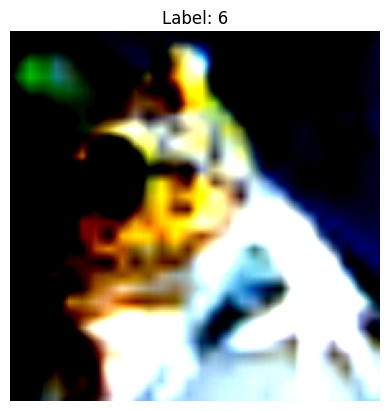

In [5]:
images, labels = next(iter(train_loader_cifar))
print(images.shape)


images = images[:1][0]  # jusqu'à 16 images
labels = labels[:1]

#batch = torch.unsqueeze(img_processed, 0)

img = images.permute(1, 2, 0)  # [H, W, C]
img = img.numpy()

plt.imshow(img)
plt.axis('off')
plt.title(f"Label: {labels[0].item()}")
plt.show()



# Fonctions

In [6]:
def train_model(nb_epoch, model, data_loader, max_batches=None):
    model.train()
    optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()


    for epoch in range(nb_epoch):
        running_loss = 0.0

        for i, (images, labels) in enumerate(data_loader):
            if max_batches is not None and i >= max_batches:
                break

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss = loss.item()
            print(f"epoch {epoch} - batch {i}: loss = {running_loss}")

        print(f"Époque {epoch+1}, perte moyenne : {running_loss / (i + 1):.4f}")

        
        
def set_resnet_model(nb_class):
    model = resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
        
    model.fc =  nn.Linear(model.fc.in_features, nb_class) 
        
    for param in model.fc.parameters():
        param.requires_grad = True
    return model

def split_data(K,dataset):
    # Initialize KFold
    kfold = KFold(n_splits=K, shuffle=True, random_state=42)

    train_loaders = []
    val_loaders = []

    # Split the dataset into 5 folds
    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"Fold {fold}:")
        print(f"Train indices: {train_idx[:5]}")
        print(f"Validation indices: {val_idx[:5]}")

        # Create subsets for training and validation
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        
        # DataLoaders
        train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

        # Stocker dans les listes
        train_loaders.append(train_loader)
        val_loaders.append(val_loader)


        print(f"Train subset size: {len(train_subset)}, Validation subset size: {len(val_subset)}")
        
    return train_loaders,val_loaders

def predict(model,input):
    with torch.no_grad():
        outputs = model(input)
        _, predicted = torch.max(outputs, 1)
        
    return predicted
    
    

In [7]:
train_data_1 = split_data(4,train_dataset_cifar)[0][0]
model_1 = set_resnet_model(10)
train_model(1,model_1,train_data_1,max_batches=3)

Fold 0:
Train indices: [0 2 3 5 8]
Validation indices: [ 1  4  6  7 13]
Train subset size: 37500, Validation subset size: 12500
Fold 1:
Train indices: [1 2 3 4 5]
Validation indices: [ 0  8 11 17 23]
Train subset size: 37500, Validation subset size: 12500
Fold 2:
Train indices: [0 1 2 4 6]
Validation indices: [ 3  5 14 15 18]
Train subset size: 37500, Validation subset size: 12500
Fold 3:
Train indices: [0 1 3 4 5]
Validation indices: [ 2  9 10 12 16]
Train subset size: 37500, Validation subset size: 12500
epoch 0 - batch 0: loss = 2.3052382469177246
epoch 0 - batch 1: loss = 2.2743568420410156
epoch 0 - batch 2: loss = 2.3679888248443604
Époque 1, perte moyenne : 0.5920


In [8]:
images_test, labels_test = next(iter(test_loader_cifar))
predicted = predict(model_1,images_test)
accuracy_score(predicted, labels_test)

0.0625

In [9]:
labels_test[11]

tensor(9)

# Explanation functions

In [10]:
def extract_datapoint_from_loader(data_loader, index=0):
    """
    Extrait un data point spécifique depuis un DataLoader
    
    Args:
        data_loader: DataLoader contenant vos données
        index: Index du data point à extraire (dans le premier batch)
    
    Returns:
        x_test: Image extraite (numpy array)
        y_test: Label correspondant
    """
    # Récupérer le premier batch
    for batch_idx, (images, labels) in enumerate(data_loader):
        if batch_idx == 0:  # Premier batch seulement
            # Extraire l'image à l'index spécifié
            x_test = images[index].numpy()  # Convertir en numpy
            y_test = labels[index].item()   # Label correspondant
            
            print(f"Shape de x_test: {x_test.shape}")
            print(f"Label y_test: {y_test}")
            
            return x_test, y_test
    
    return None, None

def prepare_data_for_shap(train_loader, num_background=50, num_test=1):
    """
    Prépare les données au bon format pour SHAP
    
    Args:
        train_loader: DataLoader d'entraînement
        num_background: Nombre d'échantillons de fond pour SHAP
        num_test: Nombre d'échantillons de test
    
    Returns:
        x_test: Échantillon(s) de test
        background_data: Données de fond pour SHAP
    """
    all_images = []
    all_labels = []
    
    # Collecter les données
    for images, labels in train_loader:
        all_images.append(images)
        all_labels.append(labels)
        
        # Arrêter si on a assez de données
        if len(torch.cat(all_images, dim=0)) >= num_background + num_test:
            break
    
    # Concaténer
    all_images = torch.cat(all_images, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    # Séparer background et test
    background_data = all_images[:num_background].numpy()
    x_test = all_images[num_background:num_background + num_test].numpy()
    
    # Si un seul échantillon de test, enlever la dimension batch
    if num_test == 1:
        x_test = x_test[0]
    
    print(f"Shape background_data: {background_data.shape}")
    print(f"Shape x_test: {x_test.shape}")
    
    return background_data
    

In [11]:
x_test = extract_datapoint_from_loader(test_loader_cifar)
background_data = prepare_data_for_shap(train_data_1)

Shape de x_test: (3, 224, 224)
Label y_test: 3
Shape background_data: (50, 3, 224, 224)
Shape x_test: (3, 224, 224)


In [12]:
background_data

array([[[[ 0.38231018,  0.38231018,  0.38231018, ...,  0.00556549,
           0.00556549,  0.00556549],
         [ 0.38231018,  0.38231018,  0.38231018, ...,  0.00556549,
           0.00556549,  0.00556549],
         [ 0.38231018,  0.38231018,  0.38231018, ...,  0.00556549,
           0.00556549,  0.00556549],
         ...,
         [ 0.15968838,  0.21106265,  0.2624369 , ..., -0.11430778,
          -0.11430778, -0.11430778],
         [ 0.15968838,  0.21106265,  0.2624369 , ..., -0.11430778,
          -0.11430778, -0.11430778],
         [ 0.17681314,  0.2281874 ,  0.27956167, ..., -0.09718303,
          -0.09718303, -0.09718303]],

        [[ 0.3277312 ,  0.3277312 ,  0.3277312 , ...,  0.2401962 ,
           0.2226892 ,  0.2226892 ],
         [ 0.3277312 ,  0.3277312 ,  0.3277312 , ...,  0.2401962 ,
           0.2226892 ,  0.2226892 ],
         [ 0.3277312 ,  0.3277312 ,  0.3277312 , ...,  0.2401962 ,
           0.2226892 ,  0.2226892 ],
         ...,
         [ 0.3977592 ,  0.41526622

In [13]:
# Batch de fond - plusieurs images prétraitées
background = images_test[:10]

# SHAP explainer
explainer = shap.GradientExplainer(model_1, background)

# Explication
#shap_values, indexes = explainer.shap_values(input_tensor)

In [14]:
shap_values = explainer.shap_values(images_test[11].unsqueeze(0)) # attention inuput de la fonction doit être de la dimension d'un batch (shape: [1, 3, 224, 224])

In [15]:
output = model_1(images_test[11].unsqueeze(0))
predicted_class = output.argmax(dim=1).item()

In [16]:
print(shap_values.shape,f'\n{predicted_class }',f'\n{output}','\n', output.shape,'\n',images_test[11].unsqueeze(0).shape)

(1, 3, 224, 224, 10) 
3 
tensor([[-1.1159,  0.1371,  0.3845,  1.1040, -1.2511,  0.5119, -0.4000, -2.0777,
         -0.4482,  0.4863]], grad_fn=<AddmmBackward0>) 
 torch.Size([1, 10]) 
 torch.Size([1, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8606442..2.5702832].


<Figure size 800x500 with 0 Axes>

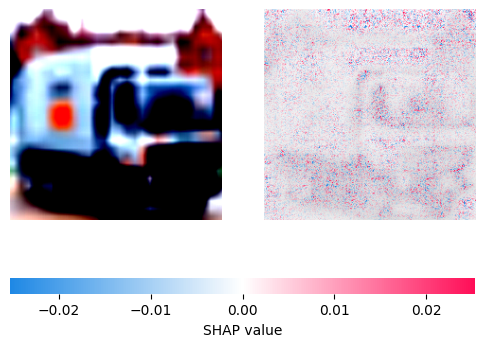

In [17]:
reshaped_shape_values = shap_values[...,8].squeeze(0) 
reshaped_shape_values_hwc = reshaped_shape_values.transpose(1, 2, 0)
image_test_hwc = images_test[11].numpy().transpose(1, 2, 0)


plt.figure(figsize=(8, 5))  # largeur, hauteur en pouces (ajuste si besoin)
#shap.image_plot(shap_values[...,8], images_test[11].unsqueeze(0).cpu().numpy())
shap.image_plot(reshaped_shape_values_hwc, image_test_hwc)


In [18]:
len(images_test[0].shape)

3

In [19]:
def shap_explain(image,model,explainer):
    try: 
        if len(image.shape) == 3 : 
            shap_values = explainer.shap_values(image.unsqueeze(0)) # attention inuput de la fonction doit être de la dimension d'un batch (shape: [1, 3, 224, 224])
            output = model(image.unsqueeze(0))
            predicted_class = output.argmax(dim=1).item()
    
        elif len(image.shape) == 4 : 
            shap_values = explainer.shap_values(image)
            output = model(image)
            predicted_class = output.argmax(dim=1).item()

    except : 
        print('Image dimension failed')
        
    reshaped_shape_values = shap_values[...,predicted_class].squeeze(0) 
    reshaped_shape_values_hwc = reshaped_shape_values.transpose(1, 2, 0)
    image_test_hwc = image.numpy().transpose(1, 2, 0)
    
    return reshaped_shape_values_hwc,image_test_hwc

    
    

# Calcul des distances entre phi 

In [20]:
# Entrainement d'une 2ème fonction f_2 sur un autre split
train_data_2 = split_data(4,train_dataset_cifar)[0][0]
model_2 = set_resnet_model(10)
train_model(1,model_2,train_data_2,max_batches=3)
explainer_2 = shap.GradientExplainer(model_2, background)


Fold 0:
Train indices: [0 2 3 5 8]
Validation indices: [ 1  4  6  7 13]
Train subset size: 37500, Validation subset size: 12500
Fold 1:
Train indices: [1 2 3 4 5]
Validation indices: [ 0  8 11 17 23]
Train subset size: 37500, Validation subset size: 12500
Fold 2:
Train indices: [0 1 2 4 6]
Validation indices: [ 3  5 14 15 18]
Train subset size: 37500, Validation subset size: 12500
Fold 3:
Train indices: [0 1 3 4 5]
Validation indices: [ 2  9 10 12 16]
Train subset size: 37500, Validation subset size: 12500
epoch 0 - batch 0: loss = 2.5707168579101562
epoch 0 - batch 1: loss = 2.302504539489746
epoch 0 - batch 2: loss = 2.272191286087036
Époque 1, perte moyenne : 0.5680


In [21]:
x = images_test[11]
phi_x_1 = shap_explain(x,model_1,explainer) # dim : (H, W, C)

In [22]:
phi_x_2 = shap_explain(x,model_2,explainer_2) # dim : (H, W, C)

In [23]:
phi_x_1[0].shape,phi_x_2[0].shape
phi_x_1, phi_x_2 = phi_x_1[0].reshape(1, -1), phi_x_2[0].reshape(1, -1) # Flatten images

euclidean_distances(phi_x_1,phi_x_2),cosine_distances(phi_x_1,phi_x_2)

(array([[1.02823748]]), array([[0.84735882]]))

# Boucle complète d'entrainement et de calcul des phi 

In [24]:
dataset_splited_4fold = split_data(4,train_dataset_cifar)

dico_phi = {}
dico_pred = {}
c = 1
for fold in dataset_splited_4fold[0]:
    print(f'\n split {c} ')
    model = set_resnet_model(10)
    train_model(1,model,fold,max_batches=3)
    explain = shap.GradientExplainer(model, background)
    phi_x_fold = shap_explain(x,model,explain)
    dico_phi[c] = phi_x_fold
    
    #predicted = predict(model,x)
    
    output = model(x.unsqueeze(0))
    predicted_class = output.argmax(dim=1).item()
    dico_pred[c] = predicted_class

    c+=1




Fold 0:
Train indices: [0 2 3 5 8]
Validation indices: [ 1  4  6  7 13]
Train subset size: 37500, Validation subset size: 12500
Fold 1:
Train indices: [1 2 3 4 5]
Validation indices: [ 0  8 11 17 23]
Train subset size: 37500, Validation subset size: 12500
Fold 2:
Train indices: [0 1 2 4 6]
Validation indices: [ 3  5 14 15 18]
Train subset size: 37500, Validation subset size: 12500
Fold 3:
Train indices: [0 1 3 4 5]
Validation indices: [ 2  9 10 12 16]
Train subset size: 37500, Validation subset size: 12500

 split 1 
epoch 0 - batch 0: loss = 2.4846084117889404
epoch 0 - batch 1: loss = 2.4160168170928955
epoch 0 - batch 2: loss = 2.4577231407165527
Époque 1, perte moyenne : 0.6144

 split 2 
epoch 0 - batch 0: loss = 2.423165798187256
epoch 0 - batch 1: loss = 2.4077811241149902
epoch 0 - batch 2: loss = 2.299137830734253
Époque 1, perte moyenne : 0.5748

 split 3 
epoch 0 - batch 0: loss = 2.471540689468384
epoch 0 - batch 1: loss = 2.290788412094116
epoch 0 - batch 2: loss = 2.36424

In [25]:
for key in dico_phi.keys():
    dico_phi[key] = dico_phi[key][0].reshape(1,-1)
    

keys = list(dico_phi.keys())
distances = {}

c=0
for i in dico_phi.keys():
    c+=1
    n= len(dico_phi.keys())
    for j in range(c,n+1):
        distances[(i,j)] = euclidean_distances(dico_phi[i], dico_phi[j])
        
distances

{(1, 1): array([[0.]]),
 (1, 2): array([[1.28695488]]),
 (1, 3): array([[1.12684882]]),
 (1, 4): array([[1.06352966]]),
 (2, 2): array([[0.]]),
 (2, 3): array([[1.04073961]]),
 (2, 4): array([[1.09725919]]),
 (3, 3): array([[0.]]),
 (3, 4): array([[1.05637984]]),
 (4, 4): array([[0.]])}

# Calcul de S  et du score MeGe:

In [32]:
#label de x = images_test[11] with images_test, labels_test = next(iter(test_loader_cifar))
label_x = labels_test[11]
print('lable de x : ',labels_test[11])
# Prédictions de x pour chaque f_i
dico_pred

lable de x :  tensor(9)


{1: 1, 2: 9, 3: 9, 4: 8}

S={δ(i,j) :f(x)=y∧f (x)=y} (3) S_d={δ(i,j) :f(x)=y⊕f (x)=y} 
xij
∀(i,j) ∈ {1,...,k}2 s.t. i �= j, ∀(x,y) ∈ Vi

In [48]:

c=0
S = {}
S_d  = {}
distances = {}
n= len(dico_phi.keys())
for i in dico_phi.keys():
    c+=1
    for j in range(c,n+1):
        if i ==j : 
            continue
        else : 
            if dico_pred[i] == int(label_x) and dico_pred[j] == int(label_x):
                distances[(i,j)] = euclidean_distances(dico_phi[i], dico_phi[j])
                S[(i,j)] = float(distances[(i,j)])
            else :
                distances[(i,j)] = euclidean_distances(dico_phi[i], dico_phi[j])
                S_d[(i,j)] = float(distances[(i,j)])
                
MeGe_x =  1 / (1 + (1 / len(S.keys()))*np.sum(list(S.values())))
        
S,S_d, MeGe_x

({(2, 3): 1.0407396127784374},
 {(1, 2): 1.2869548815799519,
  (1, 3): 1.1268488161785557,
  (1, 4): 1.0635296573013542,
  (2, 4): 1.097259189070299,
  (3, 4): 1.05637983840811},
 0.4900184196642876)